# Capstone Project - The Battle of the Neighborhoods

### Table of contents

* Introduction
* Data
* Methodology
* Results and Discussion
* Conclusion

## Introduction
Introduction where you discuss the business problem and who would be interested in this project.

Toronto is the most populous city in Canada and the fourth most populous city in North America. Toronto has population of 2,731,571(2016,Wikipedia), and is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

Canada’s largest city comes to mind as I stroll around downtown Toronto which is peppered with buzzing cafés, eateries with changing chalkboard menus, bars serving artisanal cocktails, vibrant food trucks and delis and bakeries redolent of freshly baked goods.(Read more at: https://economictimes.indiatimes.com/magazines/panache/why-toronto-is-a-paradise-for-foodies/articleshow/61895555.cms?utm_source=contentofinterest&utm_medium=text&utm_campaign=cppst)

I would like to make reginonal clustering of venue information suing Foursquare lacation to inform the cusine diversity in toronto by borough.

My work is aimed towards Entrepreneurs or Business owners who want to open a new Restaurant or grow their current business. The analysis will provide vital information that can be used by the target audience.

## Data
Data where you describe the data that will be used to solve the problem and the source of the data.

### Import necessary libraries 

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


### Data 1: Preprocessing a real world data set from wikipedia showing Neighborhoods in Toronto

#### Read in the dataset of neighborhoods in Toronto

In [2]:
raw_df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=next&oldid=942655364')
df=raw_df[0]
df.columns = ['Postcode', 'Borough', 'Neighborhood']
df.head(5)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Data Cleansing (dataset of neighborhoods in Toronto)

In [3]:
df_cleaned = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df_cleaned.head(5)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [4]:
df_cleaned = df_cleaned.groupby(['Postcode', 'Borough'], sort = False).agg(lambda x: ', '.join(x))
df_cleaned = df_cleaned.reset_index()
df_cleaned.head(5)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


### Data 2: Preprocessing a real world data set of postal code in Toronto

#### Read in the dataset of postal code of each neighborhood along with the borough name and neighborhood name in Toronto

In [5]:
location = pd.read_csv('http://cocl.us/Geospatial_data')
location.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge the data

In [6]:
df_w_location = df_cleaned.merge(location,left_on='Postcode',right_on='Postal Code')
new_df = df_w_location.drop(['Postal Code'], axis = 1)
new_df.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


### Data 3: Gathering additional information about restaurants in Toronto from Foursquare

#### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = '1FLKYONON4OIDMPRQKA4XEZ1G1IVLA0V3W0ZAA12RAGUSM0X' # my Foursquare ID
CLIENT_SECRET = 'PJTLQ2CWSYUYWP1O5G4WYDOINOPUSFOYOXS3WNYAWLGJNFOM' # my Foursquare Secret
VERSION = '20200629'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1FLKYONON4OIDMPRQKA4XEZ1G1IVLA0V3W0ZAA12RAGUSM0X
CLIENT_SECRET:PJTLQ2CWSYUYWP1O5G4WYDOINOPUSFOYOXS3WNYAWLGJNFOM


#### Geographical coordinates of Downtown Toronto

In [8]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
print('The geograpical coordinate of Toronto, CA are {}, {}.'.format(latitude, longitude))

43.6534817 -79.3839347
The geograpical coordinate of Toronto, CA are 43.6534817, -79.3839347.


## Methodology

Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

#### Function to explore neighborhoods

In [9]:
def getNearbyVenues(name, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    print('Found {} venues in {} neighborhoods.'.format(nearby_venues.shape[0], len(venues_list)))
    
    return(nearby_venues)

In [10]:
toronto_venues = getNearbyVenues(new_df['Neighborhood'],
                                 new_df['Latitude'],
                                 new_df['Longitude']
                                )

Found 2127 venues in 103 neighborhoods.


In [11]:
print(toronto_venues.shape)
toronto_venues.head(100)

(2127, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
...,...,...,...,...,...,...,...
95,Queen's Park,43.662301,-79.389494,Convocation Hall,43.660828,-79.395245,College Auditorium
96,Queen's Park,43.662301,-79.389494,Tim Hortons,43.658175,-79.390681,Coffee Shop
97,Queen's Park,43.662301,-79.389494,Tim Hortons,43.658906,-79.388696,Coffee Shop
98,Queen's Park,43.662301,-79.389494,Understudy Café at Gerstein,43.662308,-79.394098,College Cafeteria


In [12]:
#Venues per Neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",94,94,94,94,94,94
Agincourt,5,5,5,5,5,5
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",8,8,8,8,8,8
"Alderwood, Long Branch",6,6,6,6,6,6
...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6
Woburn,3,3,3,3,3,3
"Woodbine Gardens, Parkview Hill",12,12,12,12,12,12


In [13]:
print('There are {} distinct venues in {} categories.'.format(
    len(toronto_venues['Venue'].unique()),len(toronto_venues['Venue Category'].unique())))

There are 1389 distinct venues in 268 categories.


#### Extracting only restaurants from venue category list and creating a dataframe "London_restaurants"

In [14]:
toronto_restaurants = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant")]

In [15]:
print('There are {} unique categories or cusines available in Toronto.'.format(len(toronto_restaurants['Venue Category'].unique())))

There are 47 unique categories or cusines available in Toronto.


#### Analysis of each neighborhood

In [16]:
# one hot encoding
Toronto_onehot = pd.get_dummies(toronto_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = toronto_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
12,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
27,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43,Harbourfront,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,"Lawrence Heights, Lawrence Manor",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
print('There are {} restaurants in Toronto with {} different style of cuisines.'.format(Toronto_onehot.shape[0],(Toronto_onehot.shape[1]-1)))

There are 482 restaurants in Toronto with 47 different style of cuisines.


#### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category/restaurants¶

In [18]:
toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,...,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"Adelaide, King, Richmond",0.0,0.043478,0.043478,0.0,0.043478,0.0,0.0,0.0,0.043478,...,0.0,0.00,0.217391,0.043478,0.086957,0.0,0.130435,0.0,0.043478,0.000000
1,Agincourt,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,"Bathurst Manor, Downsview North, Wilson Heights",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.333333,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.000000
4,Bayview Village,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.5,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Victoria Village,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,1.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
60,Westmount,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.5,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
61,Willowdale South,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.25,0.083333,0.000000,0.166667,0.0,0.000000,0.0,0.000000,0.083333
62,Woburn,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [19]:
toronto_grouped.shape

(64, 48)

#### Top 3 restaurants for each Neighborhood based on cuisine

In [20]:
num_top_rest = 3

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_rest))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0        Restaurant  0.22
1   Thai Restaurant  0.13
2  Sushi Restaurant  0.09


----Agincourt----
                       venue  freq
0  Latin American Restaurant   1.0
1          Afghan Restaurant   0.0
2        Moroccan Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                   venue  freq
0   Fast Food Restaurant   1.0
1      Afghan Restaurant   0.0
2  Indonesian Restaurant   0.0


----Bathurst Manor, Downsview North, Wilson Heights----
                       venue  freq
0           Sushi Restaurant  0.33
1                 Restaurant  0.33
2  Middle Eastern Restaurant  0.33


----Bayview Village----
                 venue  freq
0  Japanese Restaurant   0.5
1   Chinese Restaurant   0.5
2    Afghan Restaurant   0.0


----Bedford Park, Lawrence Manor East----
                venue  freq
0          Restaurant   0.2
1  Italian Restaura

                 venue  freq
0  American Restaurant  0.13
1           Restaurant  0.13
2  Japanese Restaurant  0.09


----Stn A PO Boxes 25 The Esplanade----
                venue  freq
0  Seafood Restaurant  0.19
1  Italian Restaurant  0.14
2          Restaurant  0.14


----Studio District----
                       venue  freq
0        American Restaurant  0.25
1            Thai Restaurant  0.12
2  Latin American Restaurant  0.12


----The Annex, North Midtown, Yorkville----
                           venue  freq
0              Indian Restaurant  0.33
1  Vegetarian / Vegan Restaurant  0.33
2      Middle Eastern Restaurant  0.33


----The Beaches West, India Bazaar----
                  venue  freq
0  Fast Food Restaurant   0.4
1    Italian Restaurant   0.2
2      Sushi Restaurant   0.2


----The Danforth West, Riverdale----
                venue  freq
0    Greek Restaurant  0.47
1  Italian Restaurant  0.18
2          Restaurant  0.12


----Thorncliffe Park----
                  venue

#### Creating a new dataframe with the above results for each neighborhood

In [21]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']


for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Restaurant,Thai Restaurant,Sushi Restaurant,Fast Food Restaurant,Gluten-free Restaurant,Latin American Restaurant,Vegetarian / Vegan Restaurant,Mediterranean Restaurant,Colombian Restaurant,Modern European Restaurant
1,Agincourt,Latin American Restaurant,Vietnamese Restaurant,Hakka Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
3,"Bathurst Manor, Downsview North, Wilson Heights",Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,Bayview Village,Japanese Restaurant,Chinese Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant


#### Custering Neighborhoods using K-means
Finding the best k

In [23]:
# Creating new dataframe to determine best k value by dropping first column
toronto_clustering_testing = toronto_grouped.drop('Neighborhood', 1)

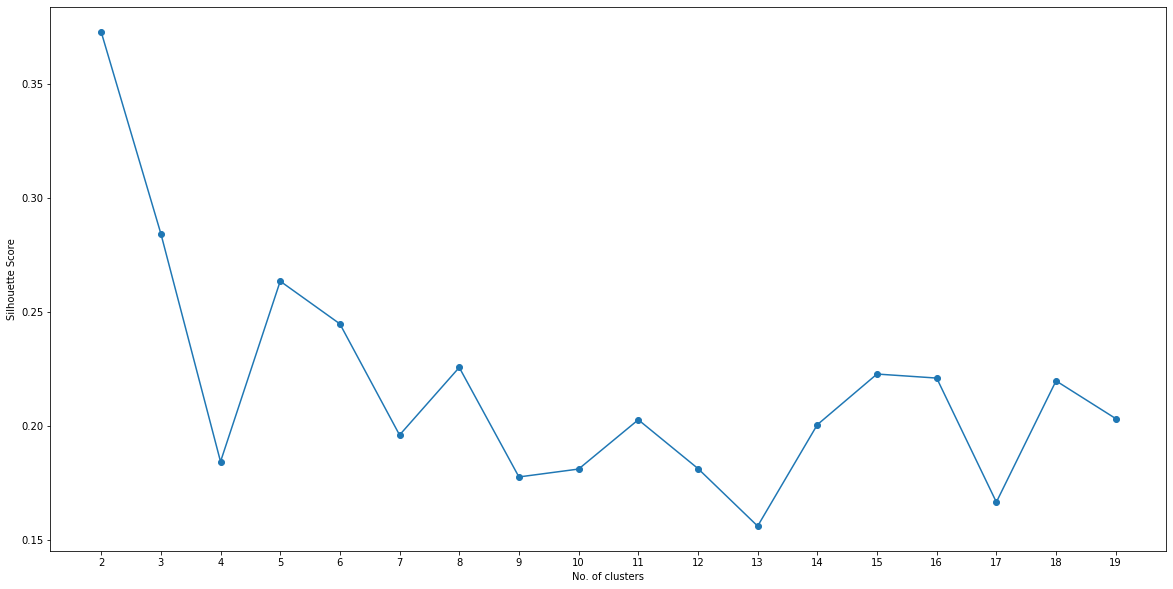

In [24]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = toronto_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    

plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [25]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

2

In [26]:
# set number of clusters
kclusters = opt

toronto_clustering_testing = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_clustering_testing)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.fillna(0)
toronto_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant,1,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
12,Harbourfront,43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant,1,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
27,Harbourfront,43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant,1,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
43,Harbourfront,43.654260,-79.360636,Izumi,43.649970,-79.360153,Asian Restaurant,1,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
53,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,Lac Vien Vietnamese Restaurant,43.721259,-79.468472,Vietnamese Restaurant,1,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


#### Number of venues belonging to each cluster

In [28]:
toronto_merged['Cluster Labels'].value_counts()

1    476
0      6
Name: Cluster Labels, dtype: int64

#### Creating map for each cluster for better visualization

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
count = 0
markers_colors = []
for lat, lon, poi, cluster, vc in zip(toronto_merged['Venue Latitude'], toronto_merged['Venue Longitude'], toronto_merged['Venue'], toronto_merged['Cluster Labels'], toronto_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

#### Final analysis of each cluster

Cluster 1

In [30]:
c1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0]+list(range(8, toronto_merged.shape[1]))]]
c1.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
99,"Rouge, Malvern",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
115,"Woodbine Gardens, Parkview Hill",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1314,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
1747,"Albion Gardens, Beaumond Heights, Humbergate, ...",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
2119,"Kingsway Park South West, Mimico NW, The Queen...",Fast Food Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


In [31]:
c1_table = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0]+[3]+[4]+[5]+list(range(8, toronto_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

Cluster 2

In [32]:
c2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0]+list(range(8, toronto_merged.shape[1]))]]
c2.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Victoria Village,Portuguese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
12,Harbourfront,Asian Restaurant,French Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
53,"Lawrence Heights, Lawrence Manor",Vietnamese Restaurant,Dim Sum Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
67,Queen's Park,Sushi Restaurant,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
100,Don Mills North,Japanese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
125,"Ryerson, Garden District",Middle Eastern Restaurant,Japanese Restaurant,Ramen Restaurant,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Modern European Restaurant,Ethiopian Restaurant,Thai Restaurant,Seafood Restaurant
217,Glencairn,Asian Restaurant,Sushi Restaurant,Japanese Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
223,"Flemingdon Park, Don Mills South",Asian Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Vietnamese Restaurant,Eastern European Restaurant,German Restaurant,French Restaurant
251,St. James Town,American Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Moroccan Restaurant,Middle Eastern Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Comfort Food Restaurant
346,"Guildwood, Morningside, West Hill",Restaurant,Mexican Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [33]:
c2_table = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0]+[3]+[4]+[5]+list(range(8, toronto_merged.shape[1]))]]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c2_table['Venue Latitude'], c2_table['Venue Longitude'], c2_table['Venue'], c2_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    count += 1
map_clusters

## Results and Discussion
Results section where you discuss the results.

Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

The results can be approached in two ways;

- If a company want to open a restaurant in preferred location and irrespective of cuisine, refer to that neighborhood in specific cluster and chose cuisine with the least common restaurant for better profits
- If a company want to open a restaurant with a preferred cuisine and irrespective of location, refer to the cluster with the least number of restaurants with that specific cuisine and select one among the neighborhoods based on company’s preference.

## Conclusion
Conclusion section where you conclude the report.

- This analysis is performed on limited data. This may be right or may be wrong. But if good amount of data is available there is scope to come up with better results. If there are lot of restaurants probably there is lot of demand. Toronto has so many restaurants, yet certain neighborhood or borough doesn’t have a specific cuisine restaurant available. As per the neighborhood or restaurant type mentioned like fast food restaurant analysis can be checked. A venue with lowest risk and competition can be identified.